In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import c
import d
import microstructure
import signals

# Data Fetching (Synthetic Data)

In [3]:
trade_data = d.fetch("data/tick", "trade.csv")
trade_data.head()

,Type,Dv,Volume,Aggressor
Date,,,,
2022-06-05 21:16:42.859000,TRADE,7.48,19,SELL
2022-06-05 21:16:42.860000,TRADE,3.90,10,SELL
2022-06-05 21:16:43.017000,TRADE,4.51,11,BUY
2022-06-05 21:16:43.017002,TRADE,2.87,7,BUY
2022-06-05 21:16:43.129000,TRADE,1.64,4,SELL


# Tick Rule

In [4]:
trade_data["price"] = trade_data["Dv"] / trade_data["Volume"]

predicted_dir = microstructure.apply_tick_rule(trade_data["price"])
predicted_dir = pd.Series(predicted_dir, index=trade_data.index)
true_dir = trade_data["Aggressor"].apply(lambda x: c.Dir.B if x == "BUY" else c.Dir.S)

trade_data["correct"] = predicted_dir == true_dir
correct = trade_data["correct"].sum()
print(f"Correct: {correct}. Accuracy: {correct/len(trade_data.index):0.2f}")

Correct: 10149. Accuracy: 0.89


## Rolling Accuracy vs Price

<AxesSubplot:xlabel='Date'>

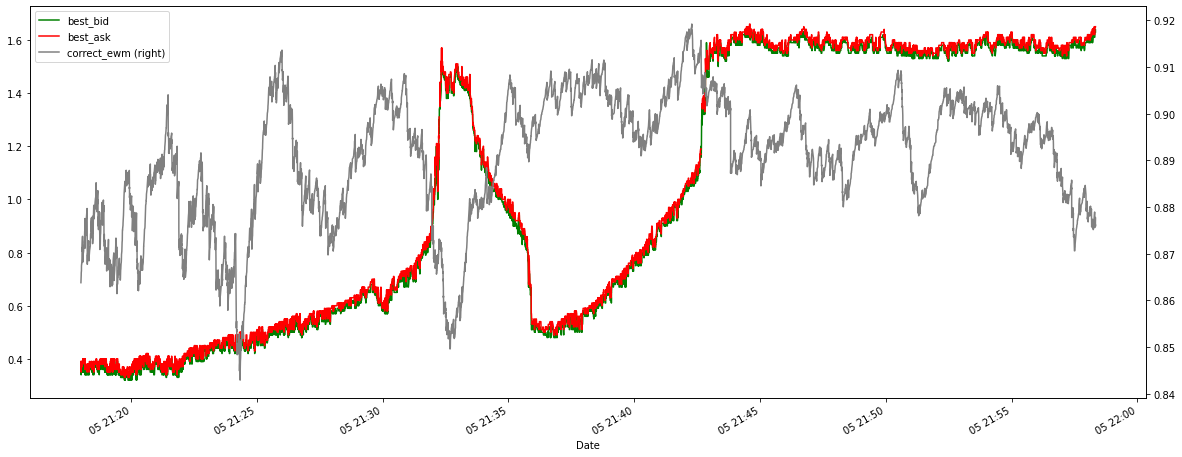

In [5]:
plt.rcParams["figure.figsize"] = (20, 8)

books_data = d.fetch_book("data/tick", "book.csv")
books_data["correct"] = predicted_dir == true_dir
books_data["correct_ewm"] = books_data["correct"].ewm(span=1000).mean()

books_data[["best_bid", "best_ask", "correct_ewm"]].iloc[500:].plot(
    secondary_y="correct_ewm", color=["g", "r", "gray"]
)

## Correctness Vs Volume Traded

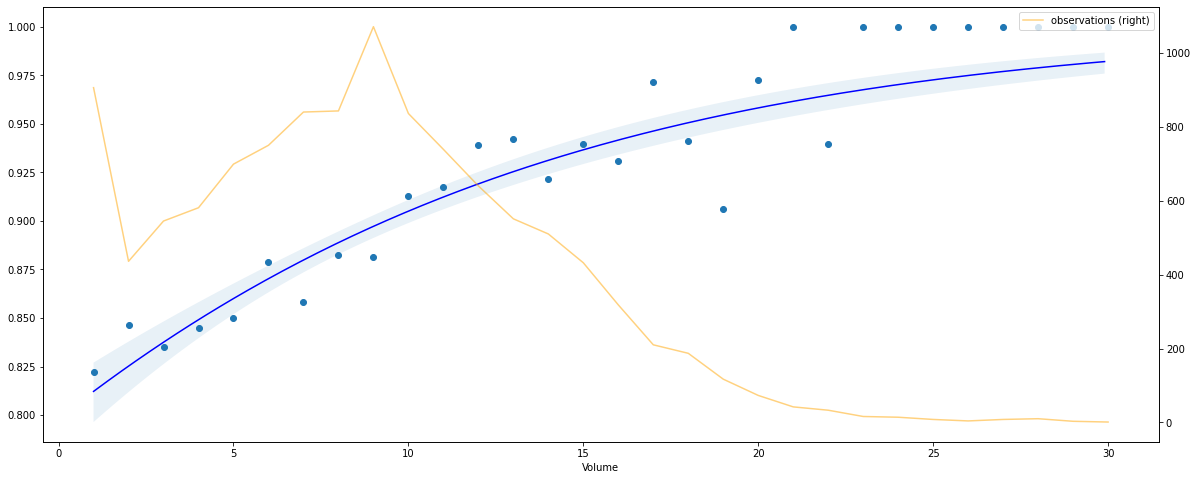

In [6]:
import statsmodels.api as sm

predictor = sm.add_constant(trade_data["Volume"])
model = sm.GLM(
    trade_data["correct"].to_numpy(),
    predictor.to_numpy(),
    family=sm.families.Binomial(),
).fit()
predictions = np.arange(trade_data["Volume"].min(), trade_data["Volume"].max(), 0.1)
outcomes = model.get_prediction(sm.add_constant(predictions)).summary_frame(alpha=0.05)
plt.plot(predictions, outcomes["mean"], color="b", label="GLM Fit")
plt.fill_between(
    predictions, outcomes["mean_ci_lower"], outcomes["mean_ci_upper"], alpha=0.1
)

by_volume = trade_data[["Volume", "correct"]].astype(int).groupby("Volume").mean()
ax = by_volume["correct"].plot(style="o")
by_volume["observations"] = trade_data.groupby("Volume").count().iloc[:, 0]
by_volume["observations"].plot(
    secondary_y="observations", ax=ax, alpha=0.5, color="orange"
)

plt.legend()

## Correctness vs Price Movement

In [7]:
books_data["mid"] = (books_data["best_bid"] + books_data["best_ask"]) / 2
books_data["price_change"] = books_data["mid"].diff().round(2)

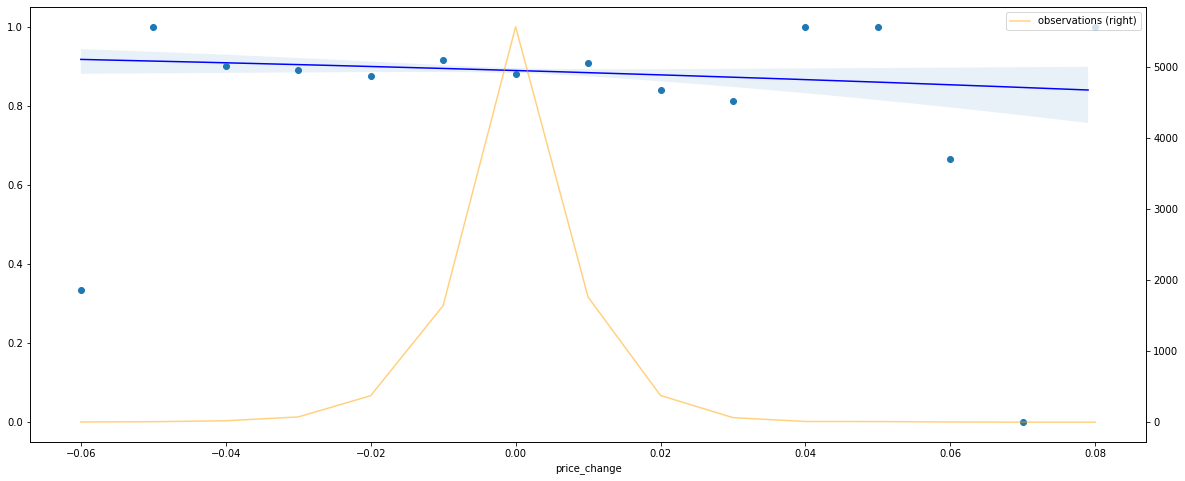

In [8]:
xy = books_data[["price_change", "correct"]].dropna().astype(float)
predictor = sm.add_constant(xy["price_change"])
model = sm.GLM(
    xy["correct"].to_numpy(), predictor.to_numpy(), family=sm.families.Binomial()
).fit()
predictions = np.arange(xy["price_change"].min(), xy["price_change"].max(), 0.001)
outcomes = model.get_prediction(sm.add_constant(predictions)).summary_frame(alpha=0.05)
plt.plot(predictions, outcomes["mean"], color="b", label="GLM Fit")
plt.fill_between(
    predictions, outcomes["mean_ci_lower"], outcomes["mean_ci_upper"], alpha=0.1
)

by_price_change = xy.groupby("price_change").mean()
ax = by_price_change["correct"].plot(style="o")
by_price_change["observations"] = xy.groupby("price_change").count().iloc[:, 0]
by_price_change["observations"].plot(
    secondary_y="observations", ax=ax, alpha=0.5, color="orange"
)
plt.legend()

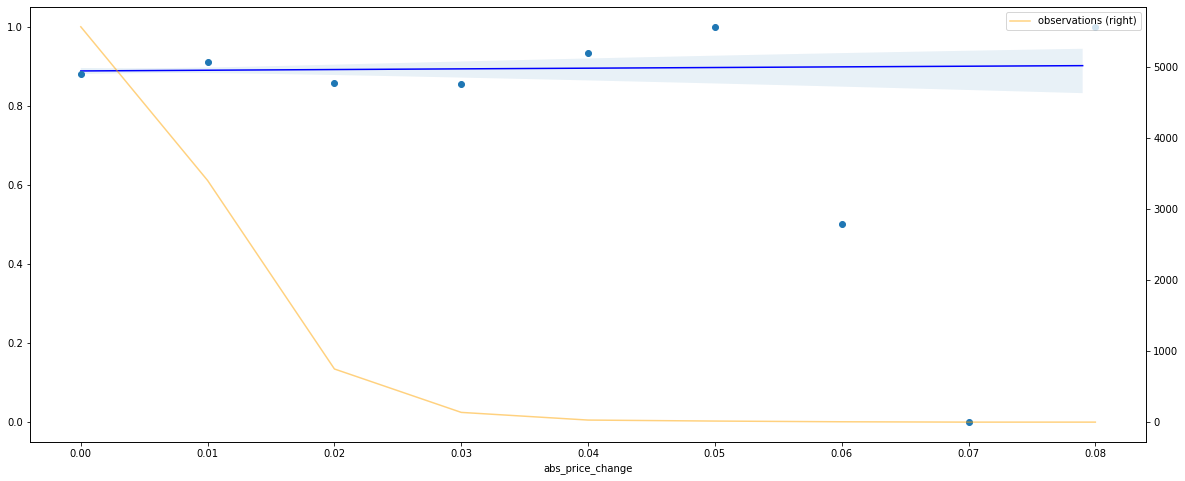

In [9]:
xy["abs_price_change"] = np.abs(xy["price_change"])
predictor = sm.add_constant(xy["abs_price_change"])
model = sm.GLM(
    xy["correct"].to_numpy(), predictor.to_numpy(), family=sm.families.Binomial()
).fit()
predictions = np.arange(
    xy["abs_price_change"].min(), xy["abs_price_change"].max(), 0.001
)
outcomes = model.get_prediction(sm.add_constant(predictions)).summary_frame(alpha=0.05)
plt.plot(predictions, outcomes["mean"], color="b", label="GLM Fit")
plt.fill_between(
    predictions, outcomes["mean_ci_lower"], outcomes["mean_ci_upper"], alpha=0.1
)

by_price_change = xy.groupby("abs_price_change").mean()
ax = by_price_change["correct"].plot(style="o")
by_price_change["observations"] = xy.groupby("abs_price_change").count().iloc[:, 0]
by_price_change["observations"].plot(
    secondary_y="observations", ax=ax, alpha=0.5, color="orange"
)
plt.legend()